In [21]:
# Import libraryu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the data
df = pd.read_parquet('Package_ML.parquet (1).gzip')

# Filter for specific zip codes (if needed)
zips = ['37013','37027','37072','37076','37115','37138','37201','37203','37204','37205',
        '37206','37207','37208','37209','37210','37211','37212','37214','37215','37216',
        '37217','37218','37219','37220','37221','37027','37064','37067','37069','37135',
        '37014','37046','37062','37179','37174','37122','37121','37087','37090','37184',
        '37138','37075','37075','37066','37148','37070','37072','37048','37188','37086',
        '37167','37127','37218','37130']
df = df[df['Zip_D'].isin(zips) & df['Zip_O'].isin(zips)]

# Handle missings values for weather data
imputer = SimpleImputer(strategy='mean')
weather_cols = ['TMIN_O', 'TMAX_O', 'PRCP_O', 'SNOW_O', 'TMIN_D', 'TMAX_D', 'PRCP_D', 'SNOW_D']
df[weather_cols] = imputer.fit_transform(df[weather_cols])
# Remove specified service codes
service_codes_to_remove = [str(code) for code in [137, 100, 51, 130, 157, 999, 28, 858, 200, 376, 374, -330, 232, 419, 7, 271, 854, 24, 101, 586, -161, 961, 6, 29, 750, -600, 50, 117, 26, -141, -162, 23, 326, -101, 57, 1, 964, 2, 22, 21, 233, 8, 247, 378, 14, -142, 297, -21, 564, 109, -103, 25, 437, -601, 987, 320]]
df = df[~df['ServiceTypeCode'].isin(service_codes_to_remove)]

print(f"Cleaned dataset shape: {df.shape}")

# Print basic info about the dataset
print(df.info())
print("\nSample of the data:")
print(df.head())


Cleaned dataset shape: (17503, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17503 entries, 0 to 17502
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ServiceTypeCode       17503 non-null  object 
 1   MailClassCode         17503 non-null  object 
 2   Distinct_event_scans  17503 non-null  int64  
 3   time_delta_minutes    17503 non-null  int32  
 4   late                  17503 non-null  int32  
 5   Zip_O                 17503 non-null  object 
 6   TMIN_O                17503 non-null  float32
 7   TMAX_O                17503 non-null  float32
 8   PRCP_O                17503 non-null  float32
 9   SNOW_O                17503 non-null  float32
 10  Zip_D                 17503 non-null  object 
 11  TMIN_D                17503 non-null  float32
 12  TMAX_D                17503 non-null  float32
 13  PRCP_D                17503 non-null  float32
 14  SNOW_D                17503 non-nul

Overall percentage of packages delivered late: 19.00%


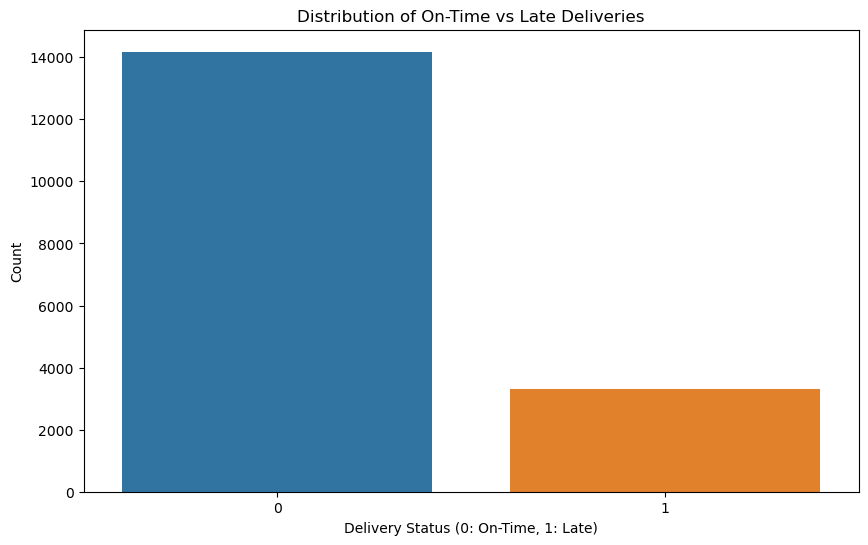

In [22]:
# Overall Late Delivery Percentage
# 1. What percentage of packages are delivered late overall?
overall_late_percentage = df['late'].mean() * 100

print(f"Overall percentage of packages delivered late: {overall_late_percentage:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='late', data=df)
plt.title('Distribution of On-Time vs Late Deliveries')
plt.xlabel('Delivery Status (0: On-Time, 1: Late)')
plt.ylabel('Count')
plt.show()

# Note: For the severe weather event comparison, we need to define what constitutes a severe weather event.
# This might require additional data or thresholds to be set.

Impact of severe weather on late deliveries by package class:
severe_weather     False      True    impact
MailClassCode                               
                0.000000  0.000000  0.000000
BB              0.031250  0.090909  0.059659
BL              0.000000       NaN       NaN
BS              0.092058  0.058824 -0.033234
EX              0.063492  0.166667  0.103175
FC              0.469388  0.833333  0.363946
G0              0.226275  0.091054 -0.135220
G1              0.154176  0.079208 -0.074968
PM              0.193620  0.110092 -0.083528
S2              0.005525  0.000000 -0.005525
SA              0.000000       NaN       NaN


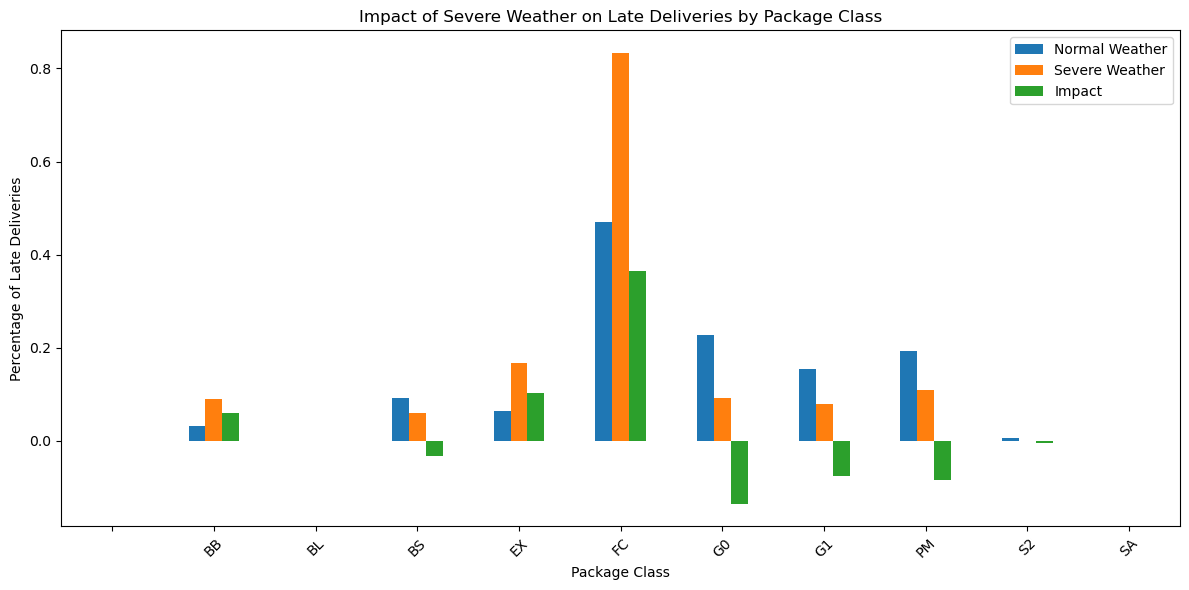

In [23]:
# Impact of Severe Weather on Package Classes
# 2. Impact of severe weather on different package classes

# Define severe weather (example: high precipitation or snow)
df['severe_weather'] = (df['PRCP_D'] > df['PRCP_D'].quantile(0.95)) | (df['SNOW_D'] > df['SNOW_D'].quantile(0.95))

# Calculate late delivery percentages for each package class during normal and severe weather
package_class_impact = df.groupby(['MailClassCode', 'severe_weather'])['late'].mean().unstack()
package_class_impact['impact'] = package_class_impact[True] - package_class_impact[False]

print("Impact of severe weather on late deliveries by package class:")
print(package_class_impact)

# Visualization
package_class_impact.plot(kind='bar', figsize=(12, 6))
plt.title('Impact of Severe Weather on Late Deliveries by Package Class')
plt.xlabel('Package Class')
plt.ylabel('Percentage of Late Deliveries')
plt.legend(['Normal Weather', 'Severe Weather', 'Impact'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Average delay (in days) for each package class during severe weather:
MailClassCode
      4.000000
FC    0.500000
PM    0.128440
G1    0.123762
G0    0.052716
BB    0.000000
BS    0.000000
EX    0.000000
S2    0.000000
Name: delay_days, dtype: float64

Overall average delay during severe weather: 0.10 days


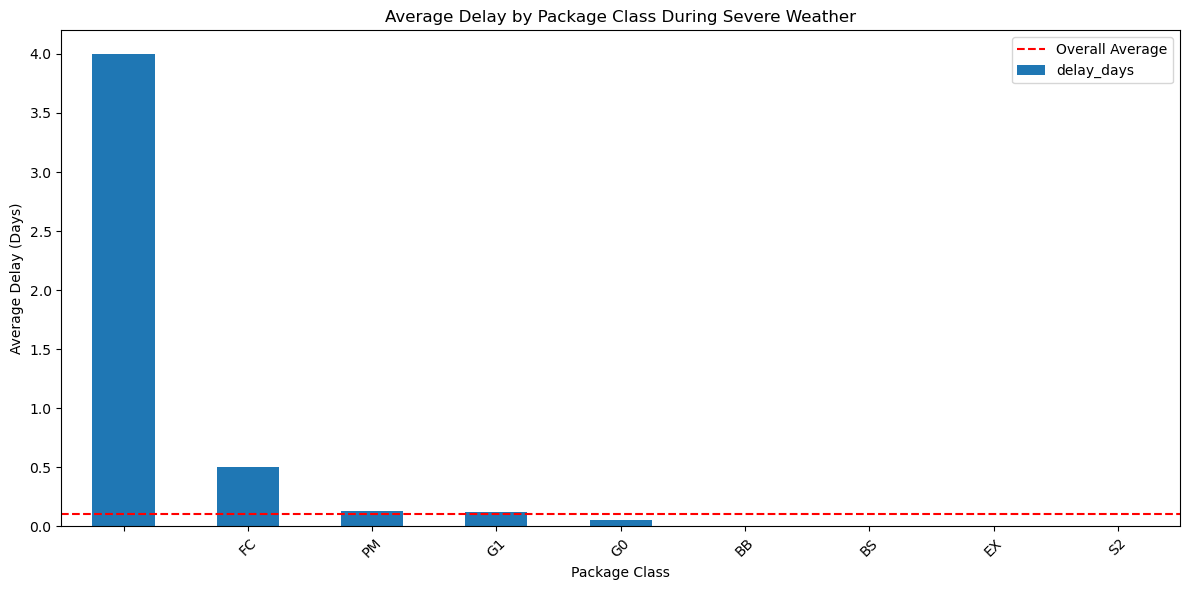

In [24]:
# Package Class with Longest Delays During Severe Weather
# 3. Which package class experiences the longest delays during severe weather?

# Calculate average delay for each package class during severe weather
df['delay_days'] = df['time_delta_minutes'] / (24 * 60)  # Convert minutes to days
severe_weather_delays = df[df['severe_weather']].groupby('MailClassCode')['delay_days'].mean().sort_values(ascending=False)

print("Average delay (in days) for each package class during severe weather:")
print(severe_weather_delays)

# Compare with overall average delay during severe weather
overall_avg_delay = df[df['severe_weather']]['delay_days'].mean()
print(f"\nOverall average delay during severe weather: {overall_avg_delay:.2f} days")

# Visualization
plt.figure(figsize=(12, 6))
severe_weather_delays.plot(kind='bar')
plt.axhline(y=overall_avg_delay, color='r', linestyle='--', label='Overall Average')
plt.title('Average Delay by Package Class During Severe Weather')
plt.xlabel('Package Class')
plt.ylabel('Average Delay (Days)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Correlation between precipitation and delays for top 10 most affected ZIP codes:
Zip_D
37215    0.033423
37013    0.029946
37062    0.022726
37205    0.022551
37090    0.017930
37174   -0.003722
37135   -0.006964
37148   -0.016637
37067   -0.019309
37075   -0.019336
dtype: float64

Correlation between precipitation and delays for top 10 least affected ZIP codes:
Zip_D
37069   -0.080241
37206   -0.080896
37188   -0.081617
37127   -0.089642
37221   -0.089889
37115   -0.092948
37212   -0.107100
37209   -0.126770
37046         NaN
37211         NaN
dtype: float64


C:\Users\Evans Sarker\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Evans Sarker\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


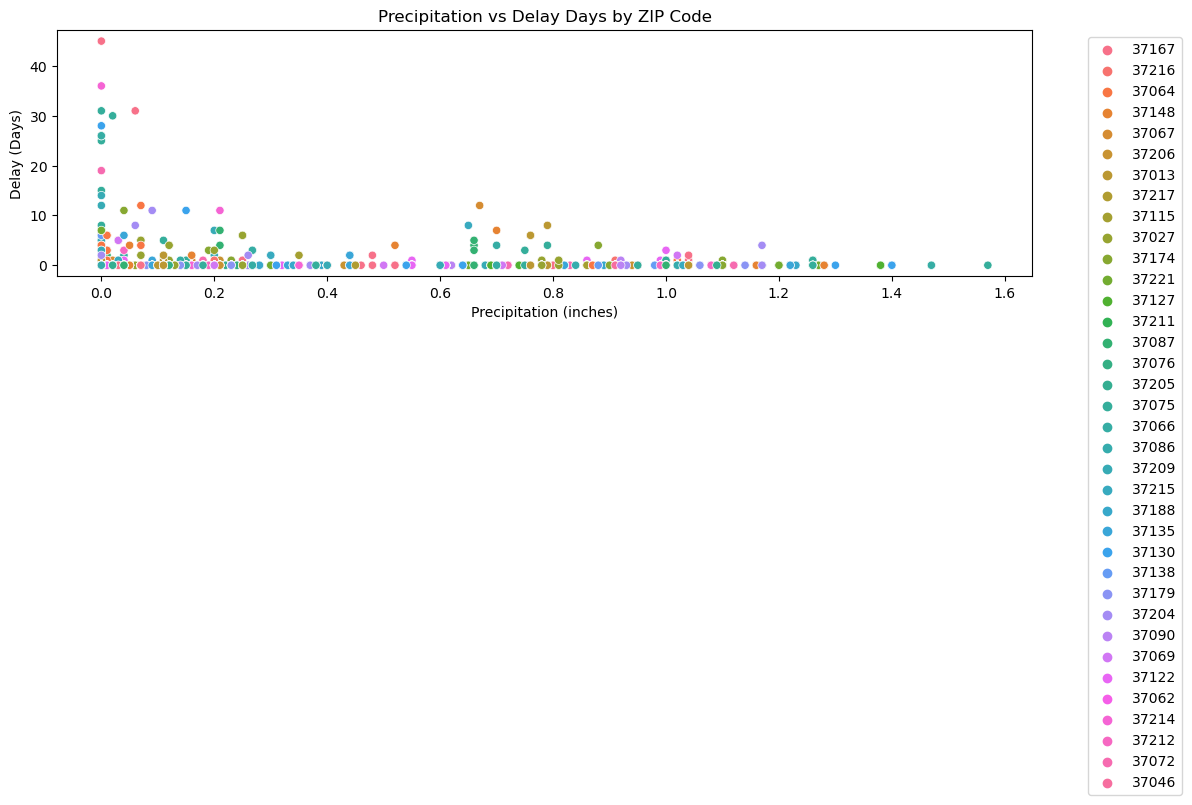

In [25]:
# Correlation Between Precipitation and Delays Across Regions
# 4. How does precipitation severity correlate with delivery delays across regions?

# Group by destination ZIP code and calculate correlation
zip_correlations = df.groupby('Zip_D').apply(lambda x: x['PRCP_D'].corr(x['delay_days'])).sort_values(ascending=False)

print("Correlation between precipitation and delays for top 10 most affected ZIP codes:")
print(zip_correlations.head(10))

print("\nCorrelation between precipitation and delays for top 10 least affected ZIP codes:")
print(zip_correlations.tail(10))

# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PRCP_D', y='delay_days', hue='Zip_D', data=df.sample(n=10000))  # Sample for better visibility
plt.title('Precipitation vs Delay Days by ZIP Code')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Delay (Days)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Average delay for different snow depth ranges:
snow_bins
0-1    0.097061
1-2    0.384615
2-3    0.070968
3-4    0.254098
4-5    0.078125
5+          NaN
Name: delay_days, dtype: float64


C:\Users\Evans Sarker\AppData\Local\Temp\ipykernel_3736\218789036.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  snow_delay = df.groupby('snow_bins')['delay_days'].mean()


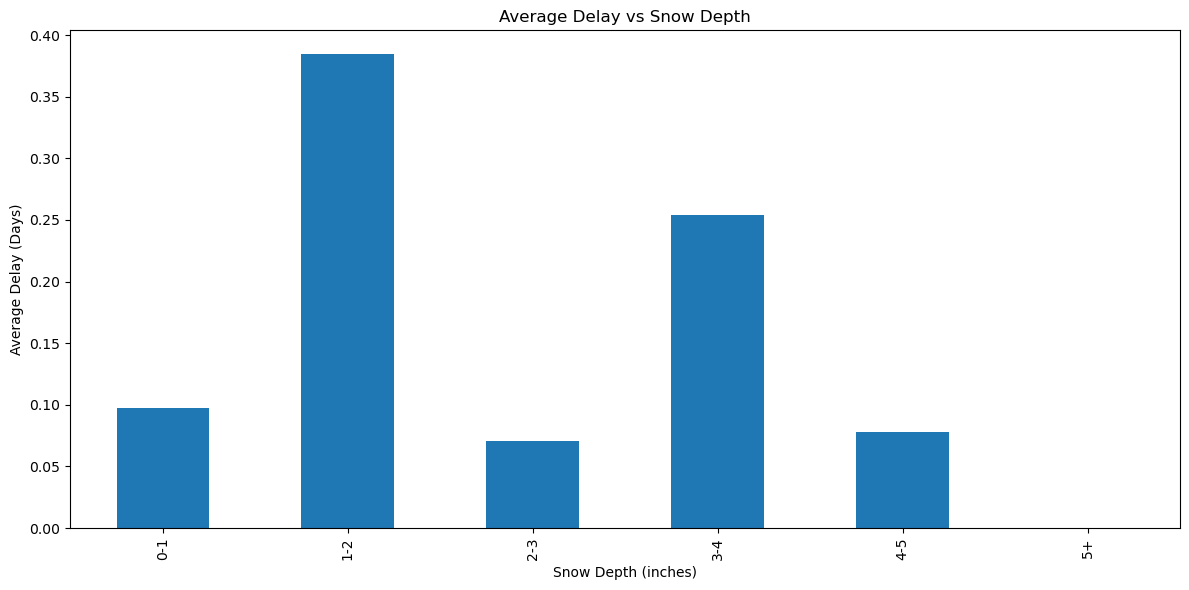

C:\Users\Evans Sarker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Evans Sarker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Evans Sarker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Evans Sarker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

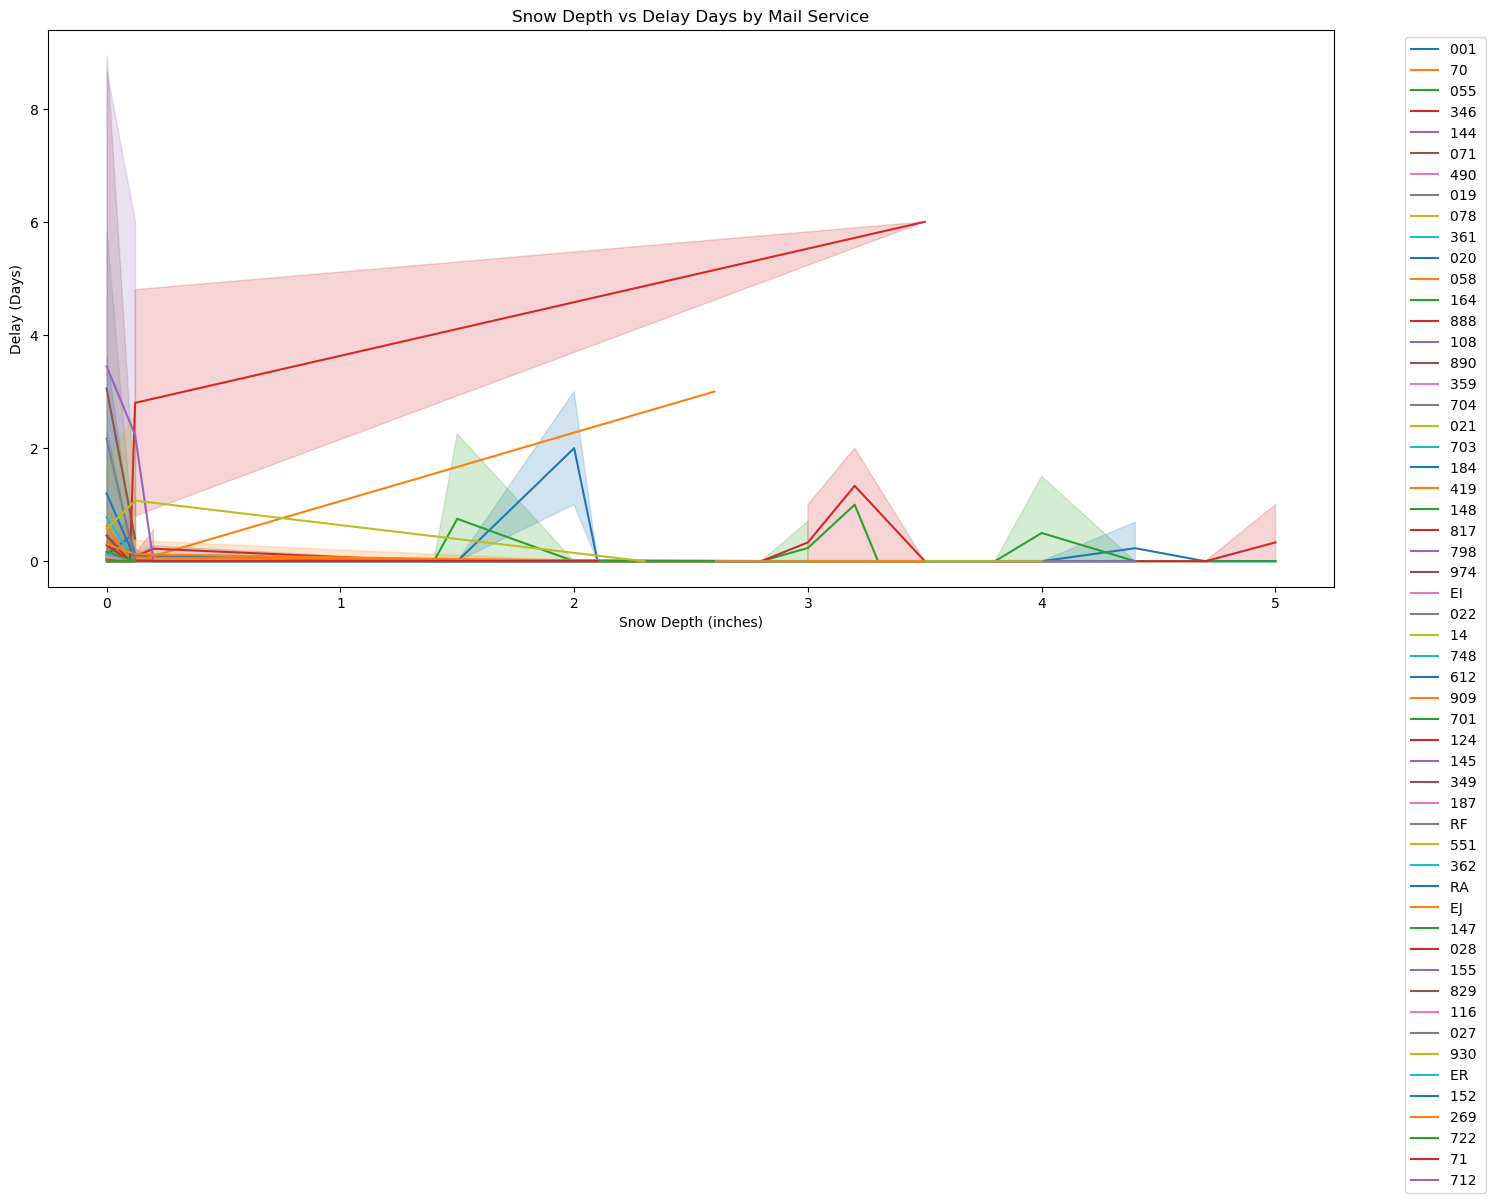

In [26]:
# Snow Depth Threshold for Delivery Delays
# 5. Is there a threshold of snow depth beyond which we see a significant spike in delivery delays?

# Create bins for snow depth
df['snow_bins'] = pd.cut(df['SNOW_D'], bins=[0, 1, 2, 3, 4, 5, np.inf], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5+'])

# Calculate average delay for each snow depth bin
snow_delay = df.groupby('snow_bins')['delay_days'].mean()

print("Average delay for different snow depth ranges:")
print(snow_delay)

# Visualization
plt.figure(figsize=(12, 6))
snow_delay.plot(kind='bar')
plt.title('Average Delay vs Snow Depth')
plt.xlabel('Snow Depth (inches)')
plt.ylabel('Average Delay (Days)')
plt.tight_layout()
plt.show()

# Repeat for different mail services
mail_services = df['ServiceTypeCode'].unique()
plt.figure(figsize=(15, 10))
for service in mail_services:
    service_data = df[df['ServiceTypeCode'] == service]
    sns.lineplot(x='SNOW_D', y='delay_days', data=service_data, label=service)

plt.title('Snow Depth vs Delay Days by Mail Service')
plt.xlabel('Snow Depth (inches)')
plt.ylabel('Delay (Days)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

On-time delivery rate for different temperature ranges:
temp_bins
<0       0.250000
0-20     0.685496
20-40    0.815710
40-60    0.867577
60-80    0.000000
80+           NaN
Name: late, dtype: float64


C:\Users\Evans Sarker\AppData\Local\Temp\ipykernel_3736\3658611248.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_performance = df.groupby('temp_bins')['late'].mean()


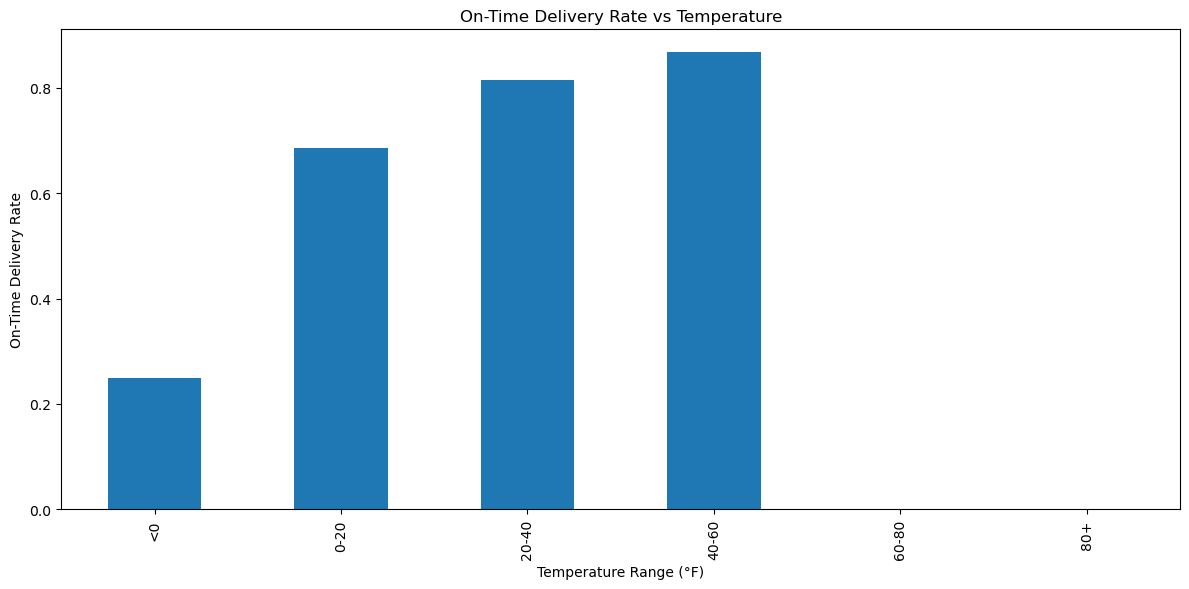


Optimal temperature range for deliveries: 40-60


In [27]:
# Impact of Temperature Extremes on Delivery Performance
# 6. What is the impact of temperature extremes on delivery performance?

# Calculate average temperature
df['avg_temp'] = (df['TMIN_D'] + df['TMAX_D']) / 2

# Create temperature bins
df['temp_bins'] = pd.cut(df['avg_temp'], bins=[-np.inf, 0, 20, 40, 60, 80, np.inf], labels=['<0', '0-20', '20-40', '40-60', '60-80', '80+'])

# Calculate on-time delivery rate for each temperature bin
temp_performance = df.groupby('temp_bins')['late'].mean()

print("On-time delivery rate for different temperature ranges:")
print(1 - temp_performance)  # 1 minus late rate gives on-time rate

# Viz
plt.figure(figsize=(12, 6))
(1 - temp_performance).plot(kind='bar')
plt.title('On-Time Delivery Rate vs Temperature')
plt.xlabel('Temperature Range (°F)')
plt.ylabel('On-Time Delivery Rate')
plt.tight_layout()
plt.show()

# Find optimal temperature range
optimal_temp = temp_performance.idxmin()
print(f"\nOptimal temperature range for deliveries: {optimal_temp}")

Percentage of packages delivered on time or early: 81.00%
Percentage of packages delivered late: 19.00%


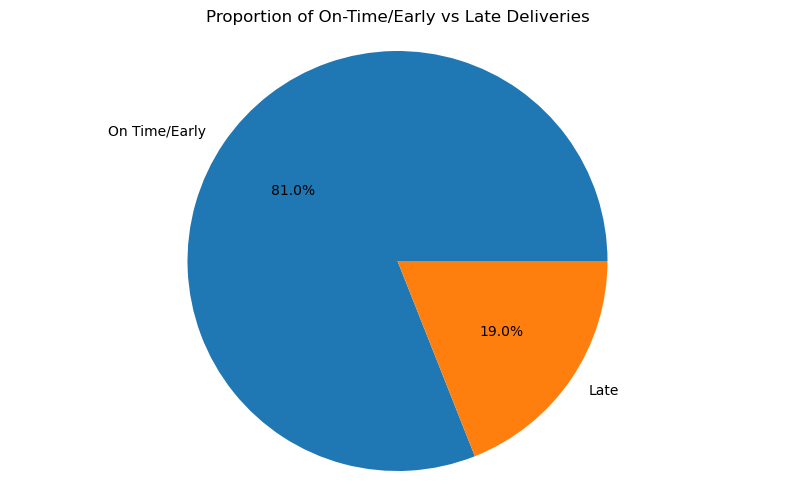

In [28]:
# OnTime vs Late Delivery Proportions
# 7. What percentage of total packages are delivered on time or early vs late?

on_time_percentage = (1 - df['late'].mean()) * 100
late_percentage = df['late'].mean() * 100

print(f"Percentage of packages delivered on time or early: {on_time_percentage:.2f}%")
print(f"Percentage of packages delivered late: {late_percentage:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
plt.pie([on_time_percentage, late_percentage], labels=['On Time/Early', 'Late'], autopct='%1.1f%%')
plt.title('Proportion of On-Time/Early vs Late Deliveries')
plt.axis('equal')
plt.show()